In [1]:
import torch
import torchvision
import sys, os
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms



In [2]:
# Load MNIST as tensors
dataset = 'FashionMNIST'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download + preprocess once
if (dataset == 'MNIST'):
    raw_train = datasets.MNIST(root=config.DATA_DIR, train=True, download=True)
    raw_test = datasets.MNIST(root=config.DATA_DIR, train=False, download=True)
if (dataset == 'FashionMNIST'):
    raw_train = datasets.FashionMNIST(root=config.DATA_DIR, train=True, download=True)
    raw_test = datasets.FashionMNIST(root=config.DATA_DIR, train=False, download=True)

X_train = raw_train.data.float().div(255.0).unsqueeze(1).to(device)   # [60000,1,28,28]
y_train = raw_train.targets.to(device)                                # [60000]
X_test  = raw_test.data.float().div(255.0).unsqueeze(1).to(device)    # [10000,1,28,28]
y_test  = raw_test.targets.to(device)



100.0%
100.0%
100.0%
100.0%


In [3]:
# Set hyperparameters

learning_rate = .005
total_epochs = 300
batch_size = 1024
dropout_probability = 0.2
print(f'training on device: {device}')

training on device: cuda


In [4]:
# Create Model
class MNISTnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B, 1, 28, 28] -> [B, 32, 28, 28]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [B, 64, 28, 28]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [B, 64, 14, 14]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),                    
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> [B, 128, 7, 7]
            nn.Flatten(),                                # -> [B, 128*7*7]
            nn.Dropout(p=dropout_probability),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64,10)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lr=learning_rate, params=model.parameters(), weight_decay=1e-4)
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 909130


In [5]:
# Training loop

# ChatGPT code to avoid slow Dataloader
def iterate_minibatches(X, y, batch_size, shuffle=True):
    N = X.size(0)
    if shuffle:
        # permutation on device; avoids CPU<->GPU traffic
        idx = torch.randperm(N, device=X.device)
    else:
        idx = torch.arange(N, device=X.device)
    for start in range(0, N, batch_size):
        s = idx[start:start+batch_size]
        # index_select keeps everything on device, no copies to host
        yield torch.index_select(X, 0, s), torch.index_select(y, 0, s)

# Back to my work
def training_loop():
    accum_loss = torch.tensor(0.0, device=device)
    last_avg = torch.tensor(float("inf"), device=device)
    scaler = torch.amp.GradScaler("cuda")
    for epoch in range(1, total_epochs + 1):
        model.train()
        accum_loss.zero_()
        batch_count = 0


        for xb, yb in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                preds = model(xb)
                loss  = criterion(preds, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                accum_loss += loss.detach()
                batch_count += 1
        scheduler.step()
        avg_loss = (accum_loss / max(1, batch_count))
    
        if epoch % 10 == 0:
            avg_loss_cpu = avg_loss.detach().cpu().item() 
            
            last_avg_cpu = (last_avg.detach().cpu().item()
                if torch.is_tensor(last_avg) else float(last_avg))
            if abs(last_avg_cpu - avg_loss_cpu) <= 0.0001 and avg_loss_cpu <= 0.02:  # early stop
                print(f"difference is {abs(last_avg_cpu - avg_loss_cpu):.6f}")
                print(f"Early stopping at epoch {epoch:5d} with loss {avg_loss_cpu:.6f}")
                break
            print(f"Epoch {epoch:5d} — avg batch loss: {avg_loss_cpu:.4f}")
            last_avg = avg_loss.detach()
    return accum_loss


In [6]:
training_loop()



Epoch    10 — avg batch loss: 0.2171
Epoch    20 — avg batch loss: 0.1329
Epoch    30 — avg batch loss: 0.0910
Epoch    40 — avg batch loss: 0.0655
Epoch    50 — avg batch loss: 0.0512
Epoch    60 — avg batch loss: 0.0385
Epoch    70 — avg batch loss: 0.0339
Epoch    80 — avg batch loss: 0.0289
Epoch    90 — avg batch loss: 0.0298
Epoch   100 — avg batch loss: 0.0240
Epoch   110 — avg batch loss: 0.0229
Epoch   120 — avg batch loss: 0.0215
Epoch   130 — avg batch loss: 0.0205
Epoch   140 — avg batch loss: 0.0169
difference is 0.000063
Early stopping at epoch   150 with loss 0.016921


tensor(0.9983, device='cuda:0')

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Switch to eval+no-grad
model.eval()
with torch.no_grad():

    # Forward pass
    y_test = y_test.cpu().numpy()
    logits = model(X_test)                           # [10000, 10]
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Accuracy
accuracy = (preds == y_test).mean() * 100
print(f"Accuracy: {accuracy:.4f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, preds)
print("\nClassification Report:")
print(class_report)


Accuracy: 93.0100%
Confusion Matrix:
[[915   0  10  11   2   1  57   0   4   0]
 [  1 984   1   9   2   0   1   0   2   0]
 [ 26   1 911   9  21   0  32   0   0   0]
 [ 18   1   4 941  19   0  17   0   0   0]
 [  3   0  52  21 883   0  40   0   1   0]
 [  0   0   0   0   0 987   0  11   0   2]
 [121   0  48  27  54   0 742   0   8   0]
 [  0   0   0   0   0   5   0 980   0  15]
 [  2   0   0   4   0   2   1   1 990   0]
 [  0   0   1   0   0   8   0  23   0 968]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.91      0.90      1000
           3       0.92      0.94      0.93      1000
           4       0.90      0.88      0.89      1000
           5       0.98      0.99      0.99      1000
           6       0.83      0.74      0.79      1000
           7       0.97      0.98      0.97      1000
           8       0.

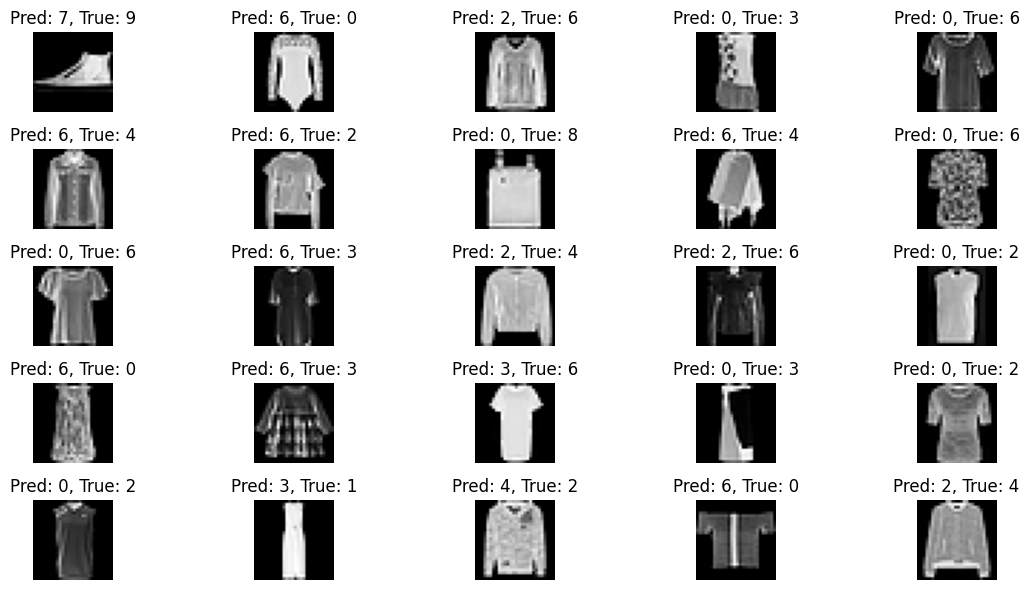

In [8]:
# Find misclassified examples
misclassified_indices = np.where(preds != y_test)[0]

# Number of images to display
num_images = 25

# Plot misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[25:25+num_images]):
    image = X_test[idx,0].view(28, 28).cpu().numpy()
    true_label = y_test[idx]
    predicted_label = preds[idx]

    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
